# Уровень заработной платы в России

In [1]:
import datetime
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import statsmodels.api as sm

from itertools import product
from scipy import stats
from tqdm import tqdm

from dateutil.relativedelta import relativedelta

warnings.filterwarnings('ignore')
%matplotlib inline

Загрузим данные

In [2]:
salary = pd.read_csv('WAG_C_M.csv', sep=';', 
                     parse_dates=['month'], index_col='month', dayfirst=True)

In [3]:
salary.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


In [4]:
salary.tail()

,WAG_C_M
month,
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0
2016-07-01,35888.0
2016-08-01,34095.0


In [5]:
salary.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 284 entries, 1993-01-01 to 2016-08-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   WAG_C_M  284 non-null    float64
dtypes: float64(1)
memory usage: 4.4 KB


Посмотрим график

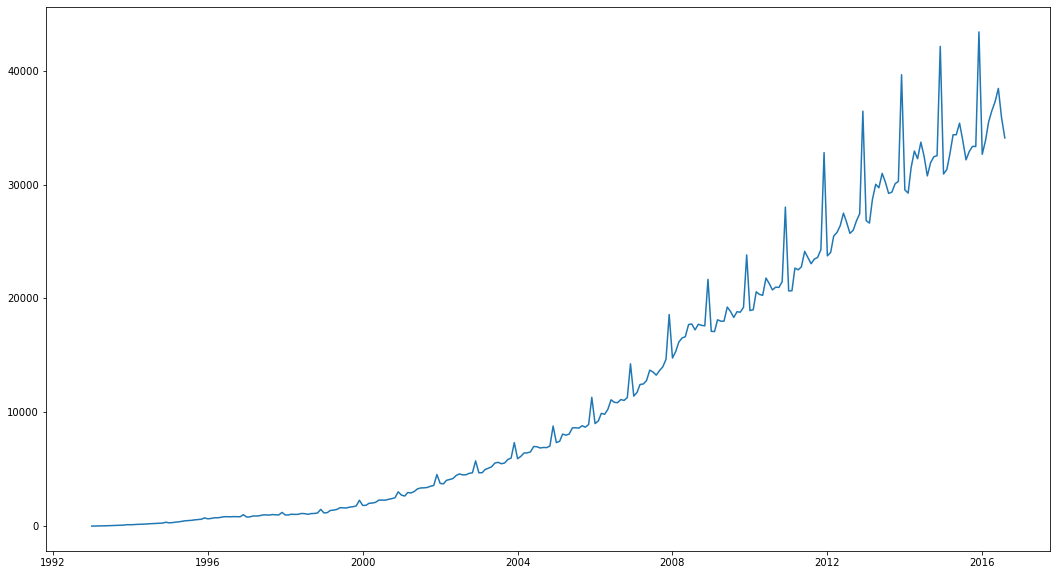

In [6]:
plt.figure(figsize=(18, 10))
plt.plot(salary['WAG_C_M'])

Можно видеть тренд, возрастающую во времени дисперсию и сезонность

Критерий Дики-Фуллера: p=0.9918495954854735


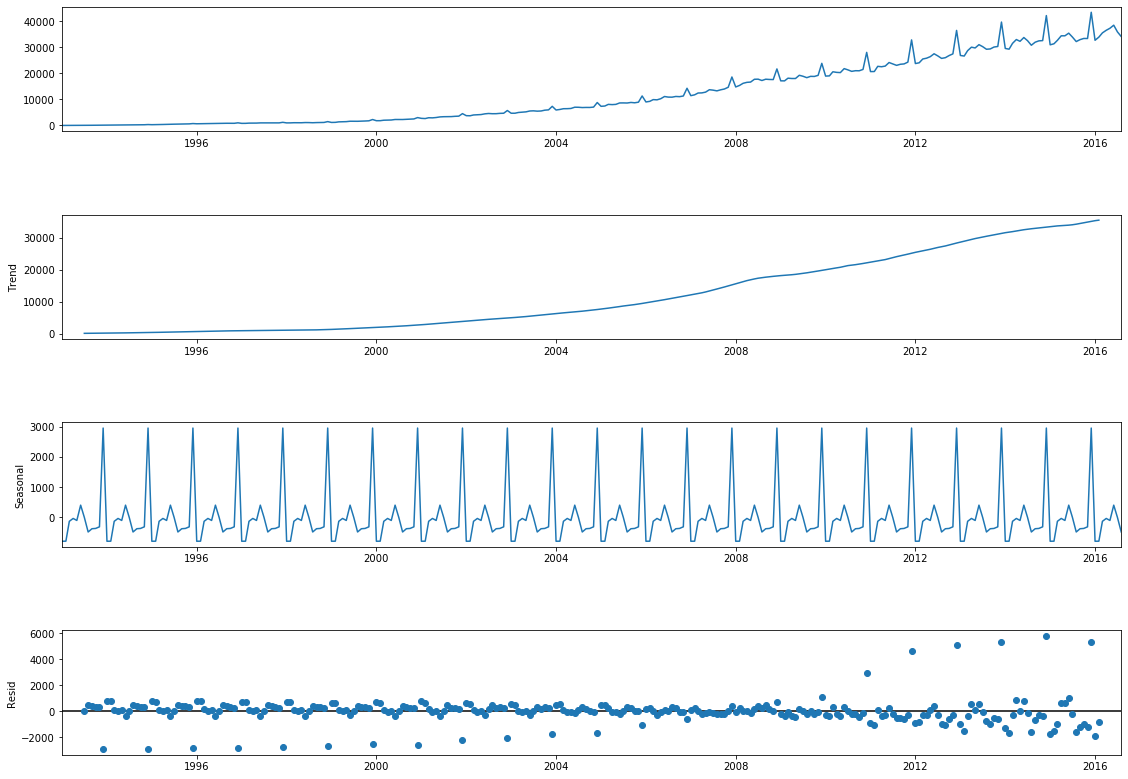

In [7]:
fig = sm.tsa.seasonal_decompose(salary).plot()
fig.set_size_inches(18, 12)
df = sm.tsa.stattools.adfuller(salary['WAG_C_M'])[1]
print(f"Критерий Дики-Фуллера: p={df}")

Очевидно наличие тренда, сезонности. Возможно, знак остотков меняется во времени.

Ряд нестационарен

Можно попробовать прологарифмировать ряд, но лучше сделать преобразования Бокса-Кокса

In [8]:
def invboxcox(y, lmbda):
    """Обратное преобразование Бокса-Кокса
    arguments:
        y : time series
        lmbda: lambda parameter of Box-Cox transform
    returns:
        inverted time series
    """
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))

Оптимальный параметр преобразования Бокса-Кокса: 0.2632017541844584
Критерий Дики-Фуллера: p=0.6968987634832758


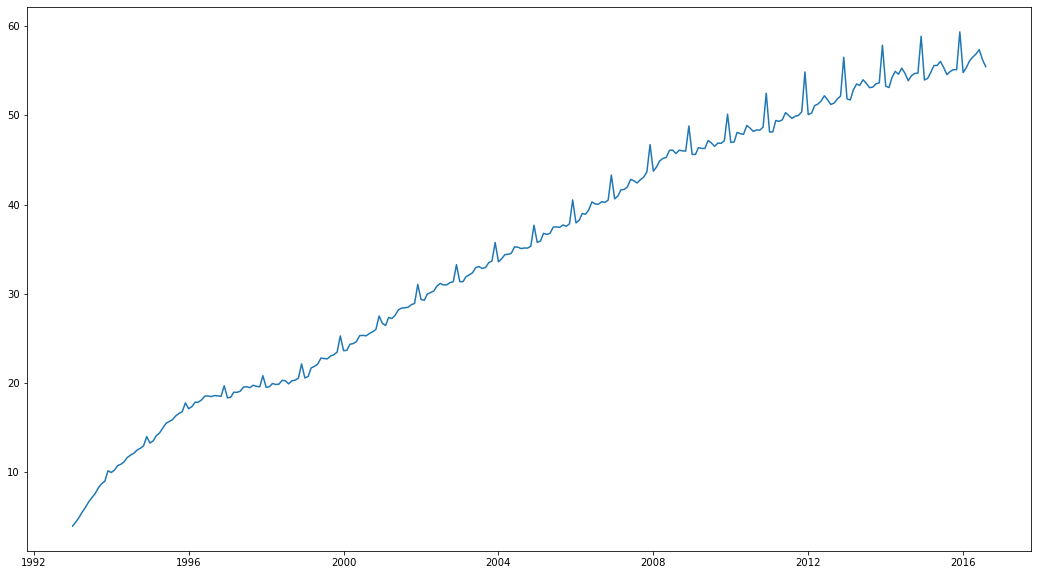

In [9]:
salary['WAG_C_M_boxcox'], lmbda = stats.boxcox(salary['WAG_C_M'])
plt.figure(figsize=(18, 10))
plt.plot(salary['WAG_C_M_boxcox'])
print(f"Оптимальный параметр преобразования Бокса-Кокса: {lmbda}")
df = sm.tsa.stattools.adfuller(salary['WAG_C_M_boxcox'])[1]
print(f"Критерий Дики-Фуллера: p={df}")

Ряд все еще нестационарен.

Попробуем сезонное дифференцирование

Критерий Дики-Фуллера: p=0.014697133494791808


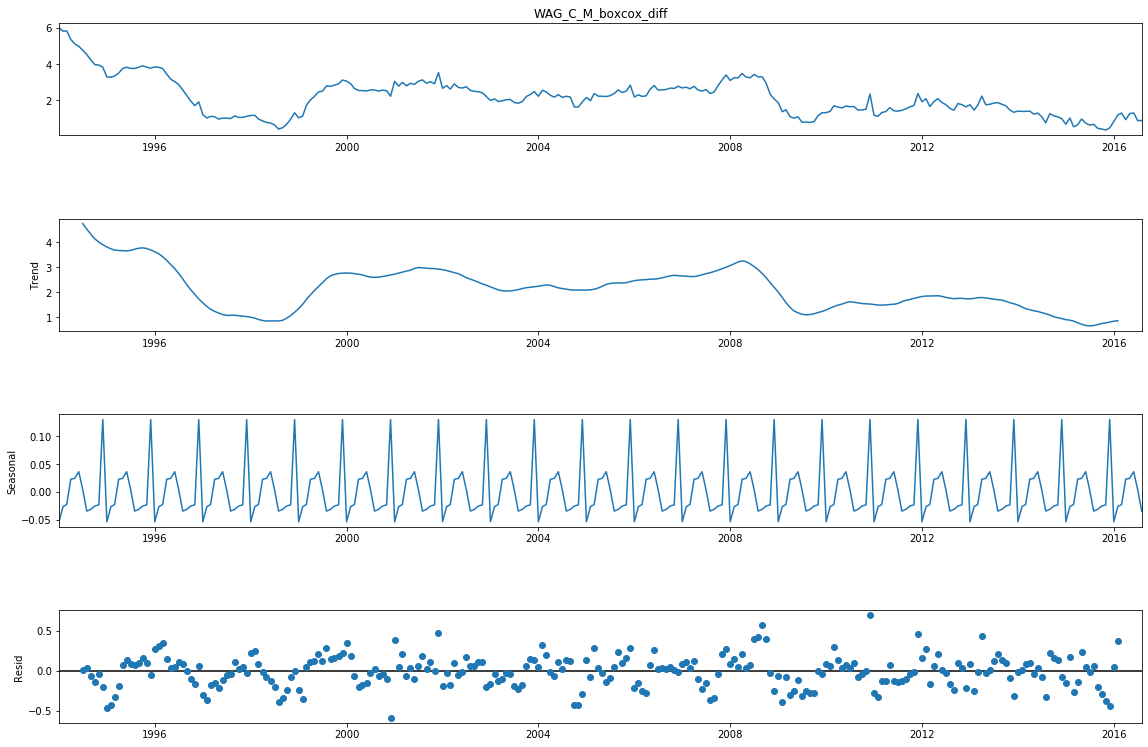

In [10]:
salary['WAG_C_M_boxcox_diff'] = (
    salary['WAG_C_M_boxcox'] - salary['WAG_C_M_boxcox'].shift(12))
fig = sm.tsa.seasonal_decompose(salary['WAG_C_M_boxcox_diff'][12:]).plot()
fig.set_size_inches(18, 12)
df = sm.tsa.stattools.adfuller(salary['WAG_C_M_boxcox_diff'][12:])[1]
print(f"Критерий Дики-Фуллера: p={df}")

Гипотеза о нестационарности отвергается, но заметен тренд. Попробуем продифференцировать еще раз

Критерий Дики-Фуллера: p=5.2036037158213736e-08


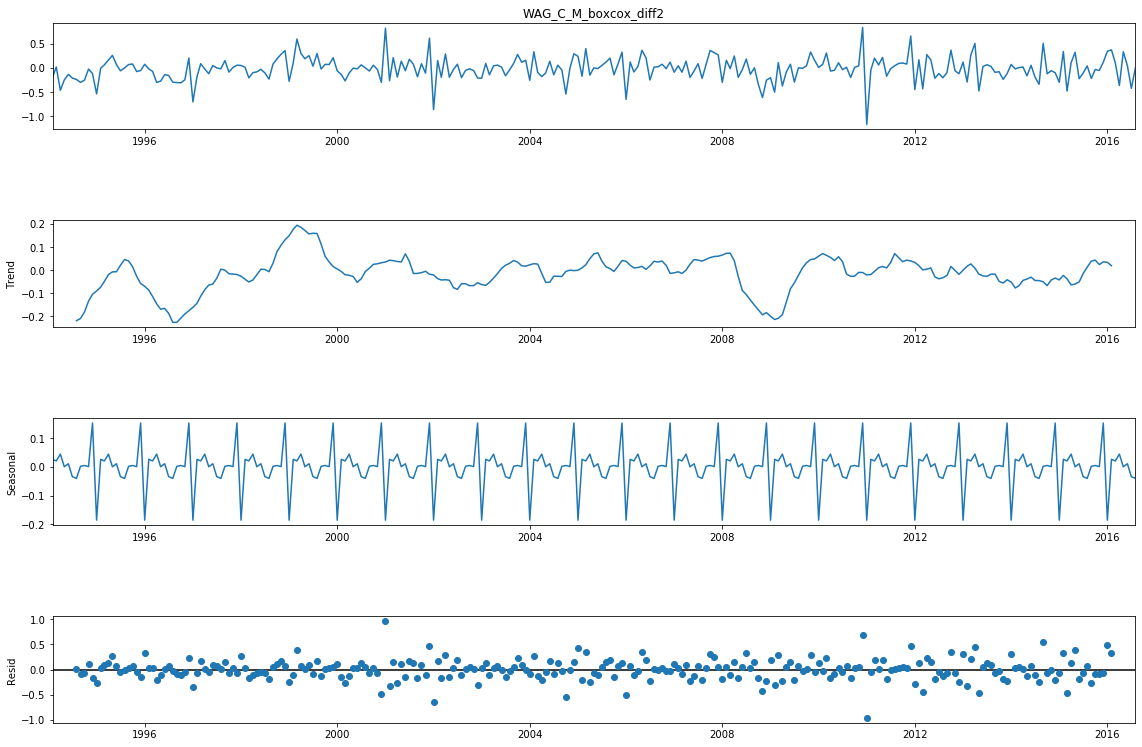

In [11]:
salary['WAG_C_M_boxcox_diff2'] = (
    salary['WAG_C_M_boxcox_diff'] - salary['WAG_C_M_boxcox_diff'].shift(1))
fig = sm.tsa.seasonal_decompose(salary['WAG_C_M_boxcox_diff2'][13:]).plot()   
fig.set_size_inches(18, 12)
df = sm.tsa.stattools.adfuller(salary['WAG_C_M_boxcox_diff2'][13:])[1]
print(f"Критерий Дики-Фуллера: p={df}")

Теперь гипотезу о нестационарности ряда можно уверенно отвергнуть.

Подберем модель.

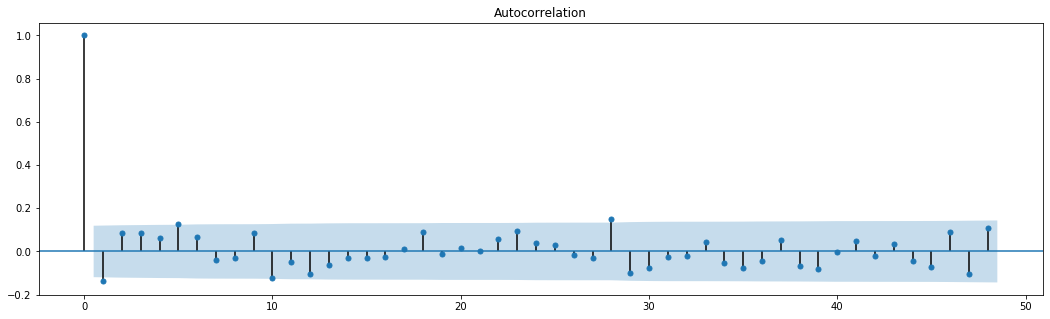

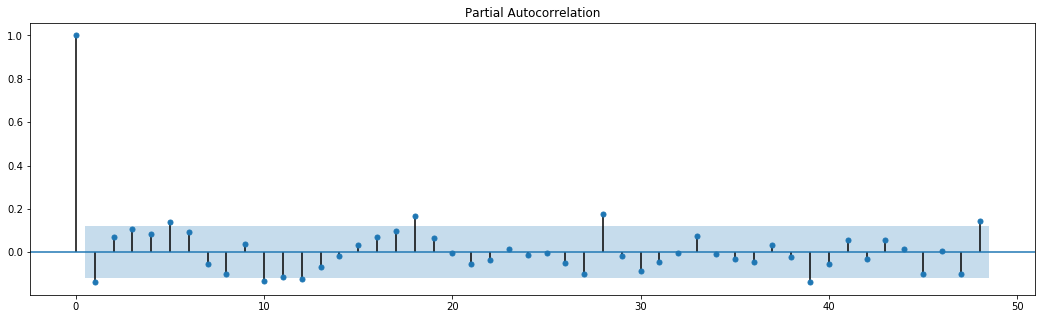

In [12]:
fig = sm.graphics.tsa.plot_acf(
    salary['WAG_C_M_boxcox_diff2'][13:].values.squeeze(), lags=48)
fig.set_size_inches(18, 5)
plt.show()

fig = sm.graphics.tsa.plot_pacf(
    salary['WAG_C_M_boxcox_diff2'][13:].values.squeeze(), lags=48)
fig.set_size_inches(18, 5)
plt.show()

Начальные приближения: Q=0, q=1, P=4, p=5

Можно было бы взять P=1, p=1, но на мой взгляд выбрасывать 48 и 5 лаг не совсем честно

In [13]:
ps = range(6)
d=1
qs = range(2)
Ps = range(5)
D=1
Qs = range(1)

In [14]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [15]:
%%time
results = []
best_aic = float("inf")


for param in tqdm(parameters_list):
    try:
        model=sm.tsa.statespace.SARIMAX(
            salary['WAG_C_M_boxcox'], order=(param[0], d, param[1]), 
            seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

100%|██████████| 60/60 [03:27<00:00,  3.47s/it]

CPU times: user 14min 30s, sys: 11min 31s, total: 26min 2s
Wall time: 3min 27s


In [16]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by='aic', ascending=True).head())

      parameters       aic
56  (5, 1, 1, 0) -5.260134
36  (3, 1, 1, 0) -4.995860
51  (5, 0, 1, 0) -4.545934
59  (5, 1, 4, 0) -4.469895
54  (5, 0, 4, 0) -4.238184


In [17]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                      WAG_C_M_boxcox   No. Observations:                  284
Model:             SARIMAX(5, 1, 1)x(1, 1, [], 12)   Log Likelihood                  10.630
Date:                             Fri, 22 May 2020   AIC                             -5.260
Time:                                     23:08:22   BIC                             23.557
Sample:                                 01-01-1993   HQIC                             6.310
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2016      0.436      0.462      0.644      -0.653       1.057
ar.L2          0.0993      

Критерий Стьюдента: p=0.296126665606961
Критерий Дики-Фуллера: p=1.977725708116758e-29


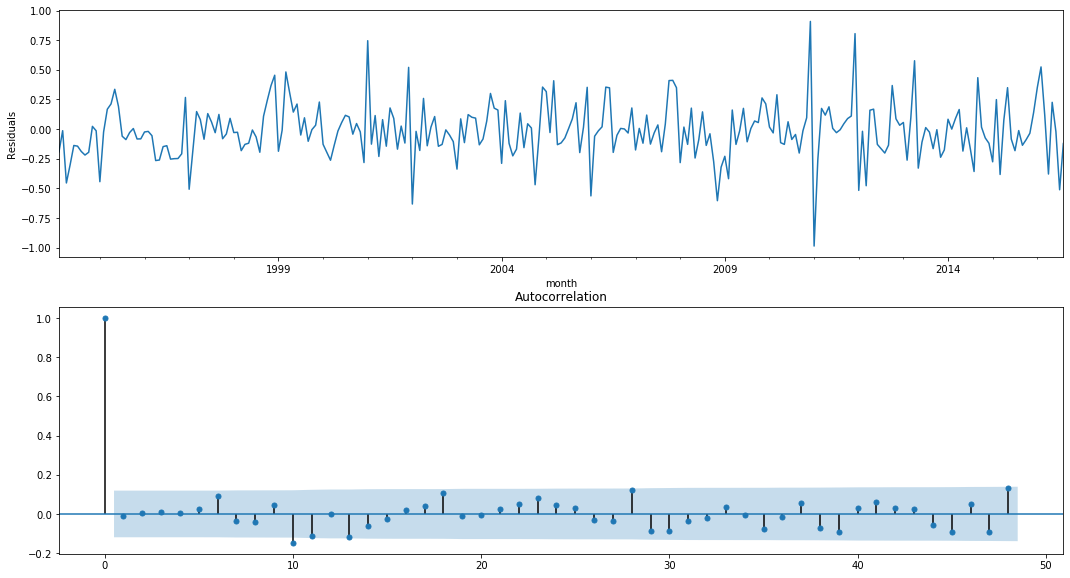

In [18]:
plt.figure(figsize=(18, 10))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(
    best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

st = stats.ttest_1samp(best_model.resid[13:], 0)[1]
df = sm.tsa.stattools.adfuller(best_model.resid[13:])[1]
print(f"Критерий Стьюдента: p={st}")
print(f"Критерий Дики-Фуллера: p={df}")

Критерий Стьюдента не отвергает гипотезу о несмещенности остатков.

Критерий Дики-Фуллера сообщает, что ряд стационарен.

По коррелограмме можно видеть неавтокоррелированность остатков.

Посмотрим, насколько хорошо модель описывает данные

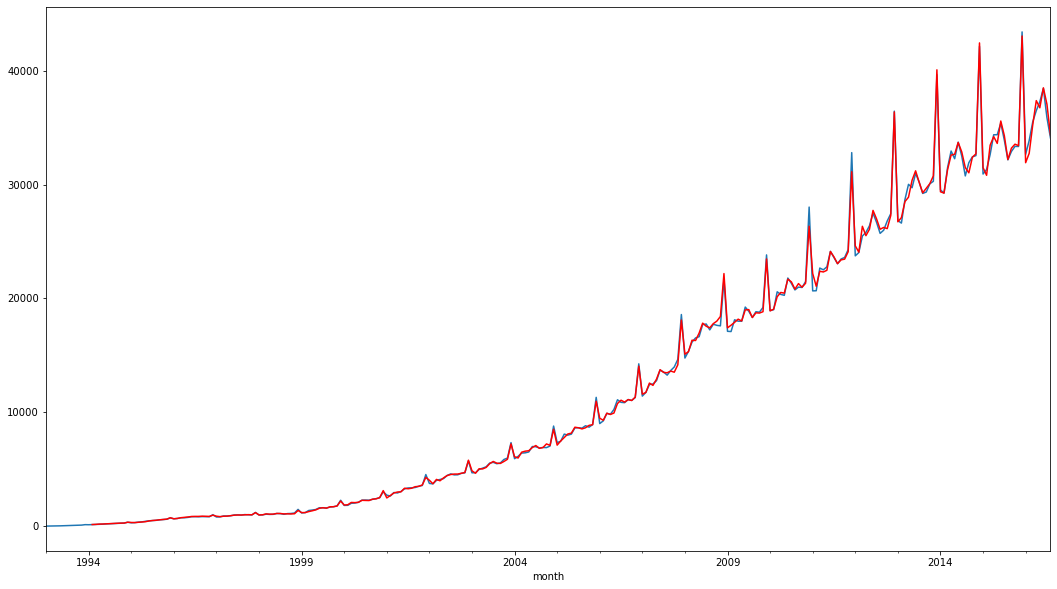

In [19]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(18, 10))
salary['WAG_C_M'].plot()
salary['model'][13:].plot(color='r')
plt.show()

Выглядит неплохо.

Сделаем прогноз

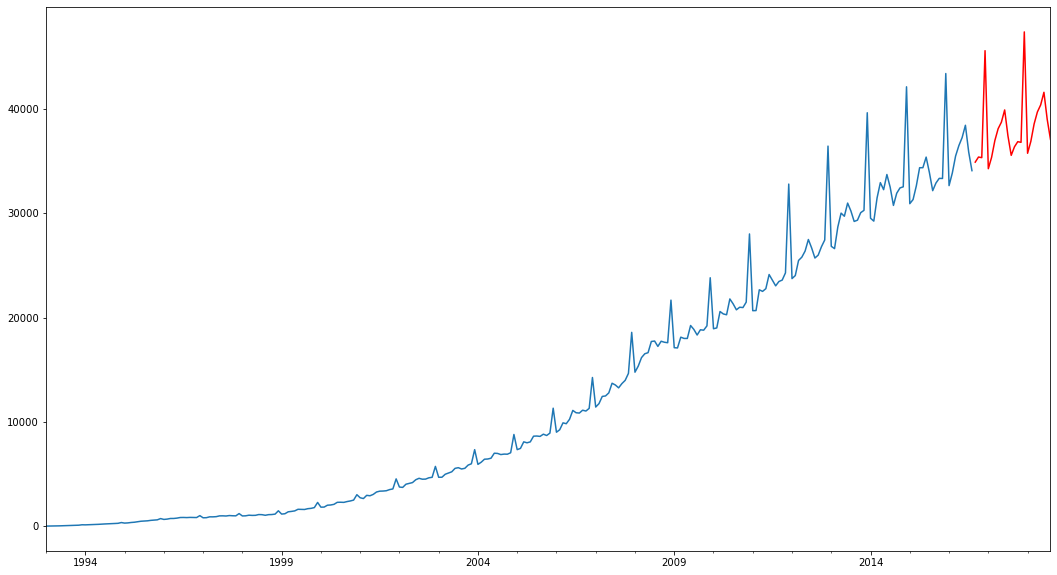

In [20]:
salary_copy = salary[['WAG_C_M']].copy()
date_list = [salary.index[-1] + relativedelta(months=x + 1) for x in range(24)]

future = pd.DataFrame(index=date_list, columns=salary_copy.columns)

salary_copy = pd.concat([salary_copy, future])
salary_copy['forecast'] = invboxcox(
    best_model.predict(start=salary.shape[0], end=salary.shape[0]+24), lmbda)

plt.figure(figsize=(18, 10))
salary_copy['WAG_C_M'].plot()
salary_copy['forecast'].plot(color='r')
plt.show()

Предсказание выглядит адекватным, визуально отражает тренд, сезонность и рост дисперсии.